Загружаем тестовую и тренеровочную выборки

In [139]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('H_train.csv')
df_test  = pd.read_csv('H_test.csv')
df_test2  = pd.read_csv('H_test.csv')

# Просматриваем данные
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Определим размеры датасета

In [85]:
df_train.shape

(1460, 81)

Посмотрим нашу целевую переменную SalePrice

In [86]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Распределение далеко от идеального. Стандартное отклонение слишком велико, а разница между минимум и 25% процентилем и 75% процентилем и максимумом слишком большая.

Проведем больше наблюдений и найдем ассиметрию и эксцесс

In [87]:
print("Ассиметрия: %f" % df_train['SalePrice'].skew())
print("Эксцесс: %f" % df_train['SalePrice'].kurt())

Ассиметрия: 1.882876
Эксцесс: 6.536282


Попытаемся избавиться от этой проблемы, используя логарифмическое преобразование. Создадим два графика: один с исходными данными, другой с применением упомянутой выше техники:

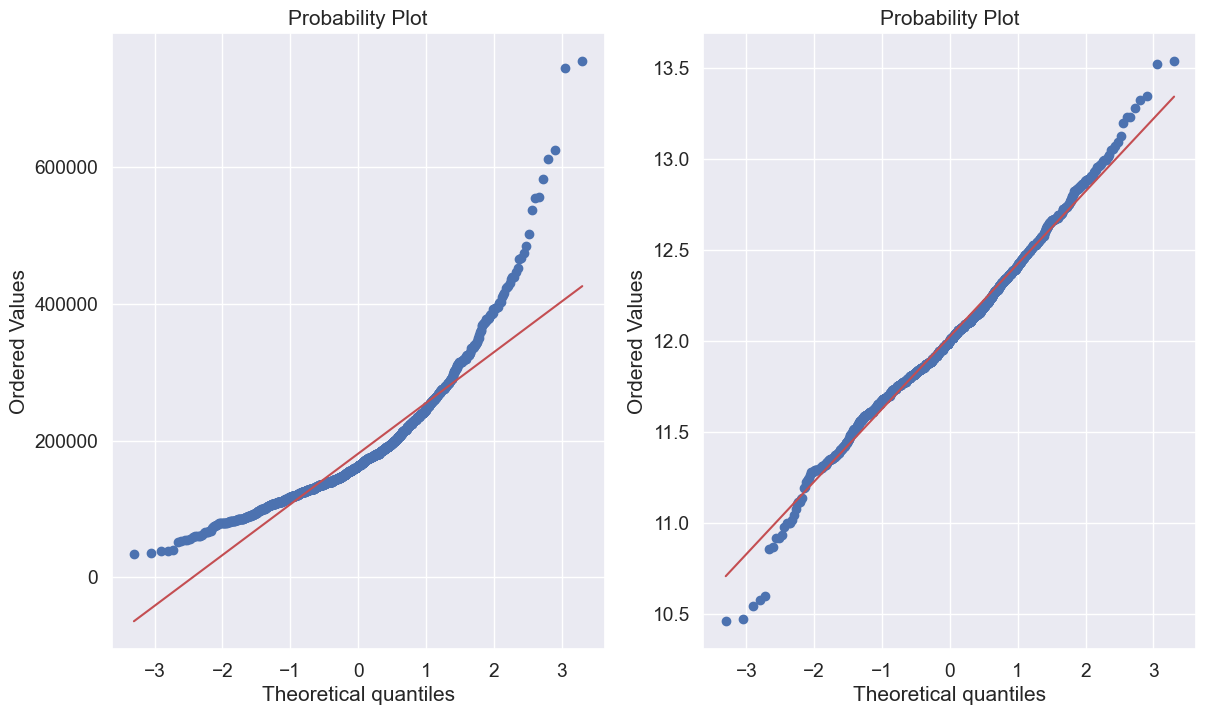

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

fig = plt.figure(figsize = (14,8))

# Распределение на необработанных данных
fig.add_subplot(1,2,1)
res = stats.probplot(df_train['SalePrice'], plot=plt)

# Распределение при условии, что мы прологарифмировали 'SalePrice'
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['SalePrice']), plot=plt)

Этот метод исправил ситуацию. Теперь наша задача – совершить логарифмирование не просто испытательным путем на графике, а применить данный метод ко всей тренировочной выборке:


In [89]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

Теперь посмотрим, с какими признаками коррелирует целевая переменная SalePrice

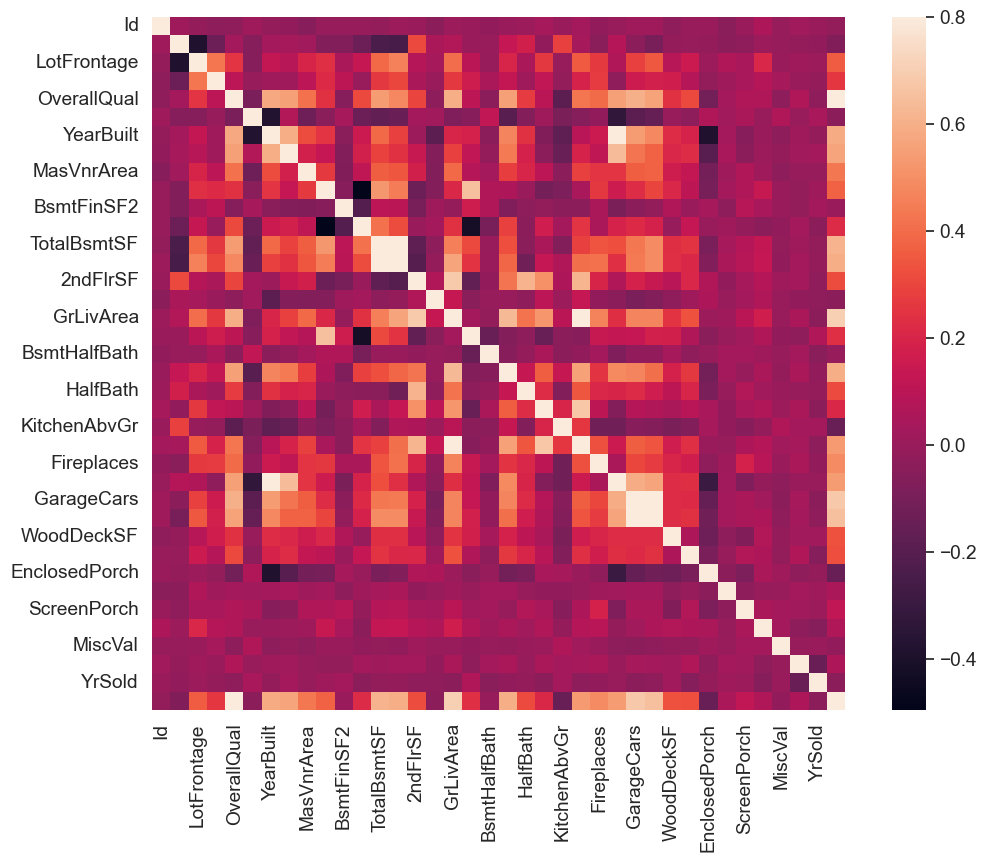

In [90]:
#удалим все столбца типа object
df_train = df_train.select_dtypes(exclude=['object'])
# Матрица корреляции
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Попробуем усеченный вариант и сократим количество коррелирующих признаков до 10:

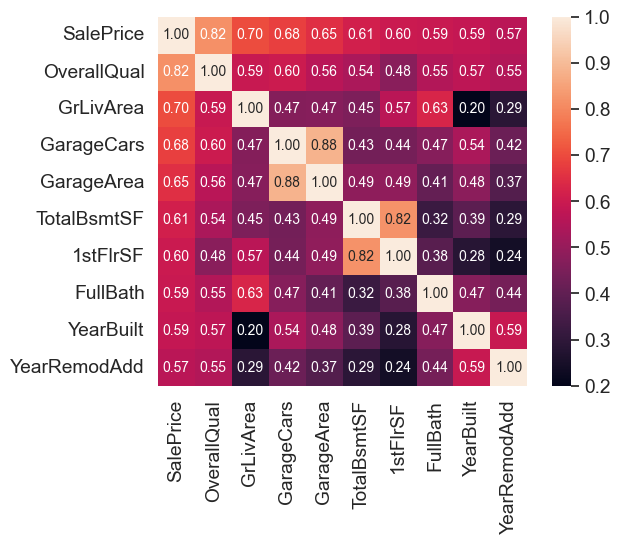

In [91]:
k = 10 # количество коррелирующих признаков, которое мы хотим увидеть
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Теперь мы видим, что лучше всего SalePrice коррелирует с GrLivArea, OverallQual и GarageCars. Проверим эти переменные на выбросы:

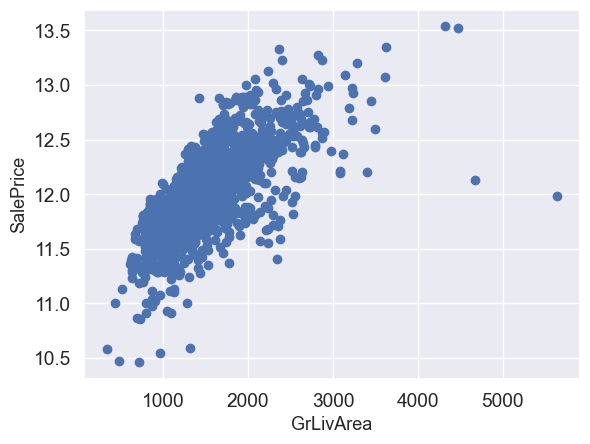

In [92]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

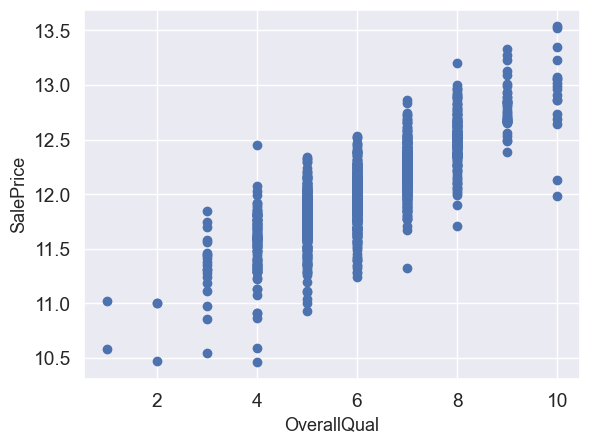

In [93]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['OverallQual'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

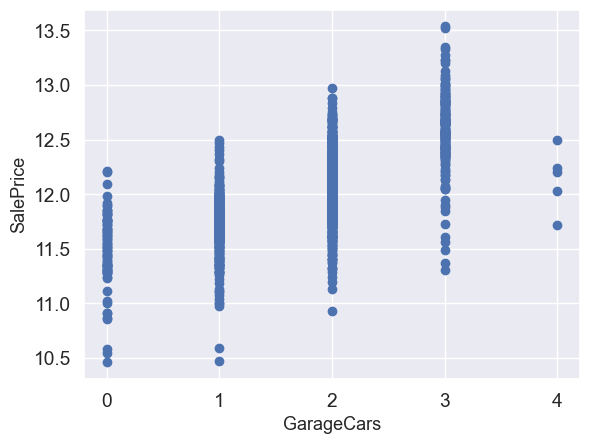

In [94]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GarageCars'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageCars', fontsize=13)
plt.show()

Выбросы незначительны. Однако если мы удалим несколько самых выделяющихся значений, то результат модели улучшится.

In [95]:
df_train = df_train.drop(df_train[(df_train['OverallQual'] > 9) & (df_train['SalePrice'] < 220000)].index)
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[(df_train['GarageCars'] > 3) & (df_train['SalePrice'] < 300000)].index)

Найдем пропущенный значения

In [96]:
df_train.isnull().sum().sort_values(ascending=False).head(20)

LotFrontage      257
GarageYrBlt       81
MasVnrArea         7
Id                 0
OpenPorchSF        0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageCars         0
GarageArea         0
WoodDeckSF         0
EnclosedPorch      0
HalfBath           0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
BedroomAbvGr       0
dtype: int64

Text(0.5, 1.0, 'Общее количество недостающих значений  (%)')

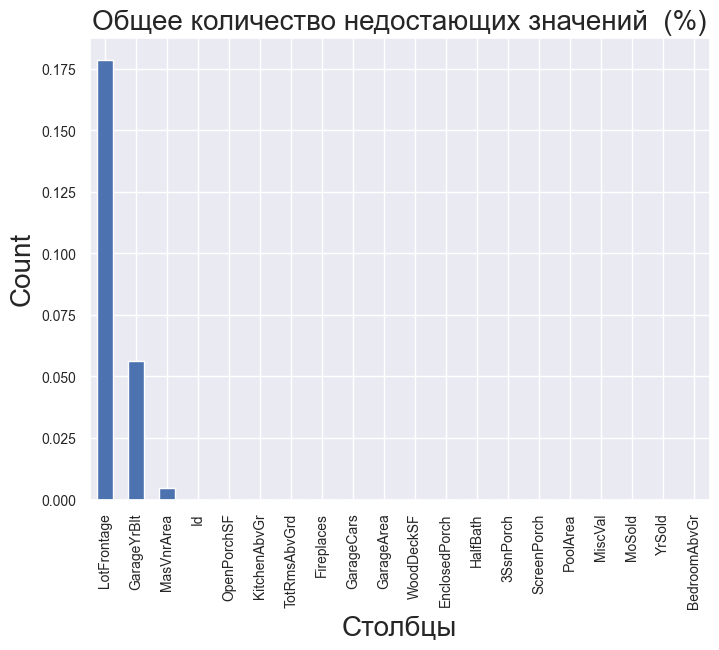

In [97]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

# Гистограмма
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Столбцы", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Общее количество недостающих значений  (%)", fontsize = 20)

Процент пропущенных значений крайне невысок. Заменим отсутствующие значения средними по столбцу.

In [98]:
df_train['LotFrontage'].fillna(df_train['LotFrontage'].mean(), inplace = True)
df_train['GarageYrBlt'].fillna(df_train['GarageYrBlt'].mean(), inplace = True)
df_train['MasVnrArea'].fillna(df_train['MasVnrArea'].mean(), inplace = True)

In [99]:
# Удаляем бесполезный столбец
df_train = df_train.drop(columns=['Id'], axis=1)

Данные подготовлены, теперь можно занятся обучением модели. Но для начала подготовим тестовый датасет.

In [100]:
df_test = df_test.select_dtypes(exclude=['object'])
df_test= df_test.drop(columns=['Id'], axis=1)

In [129]:
df_test['LotFrontage'].fillna(df_test['LotFrontage'].mean(), inplace = True)
df_test['GarageYrBlt'].fillna(df_test['GarageYrBlt'].mean(), inplace = True)
df_test['MasVnrArea'].fillna(df_test['MasVnrArea'].mean(), inplace = True)
df_test['BsmtFinSF1'].fillna(df_test['BsmtFinSF1'].mean(), inplace = True)
df_test['BsmtFinSF2'].fillna(df_test['BsmtFinSF2'].mean(), inplace = True)
df_test['TotalBsmtSF'].fillna(df_test['TotalBsmtSF'].mean(), inplace = True)
df_test['BsmtFullBath'].fillna(df_test['BsmtFullBath'].mean(), inplace = True)
df_test['BsmtHalfBath'].fillna(df_test['BsmtHalfBath'].mean(), inplace = True)
df_test['GarageCars'].fillna(df_test['GarageCars'].mean(), inplace = True)
df_test['GarageArea'].fillna(df_test['GarageArea'].mean(), inplace = True)
df_test['BsmtUnfSF'].fillna(df_test['BsmtUnfSF'].mean(), inplace = True)

In [133]:
df_test.isnull().sum().sum()

0

In [130]:
Y = df_train['SalePrice']
X = df_train.drop(['SalePrice'], axis = 1)

In [131]:
print(X.shape)
print(df_test.shape)

(1437, 36)
(1459, 36)


Подключаем необходимые модели и начинаем их обучение!

In [134]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas = (0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
ridge_cv.fit(X, Y)
ridge_cv_preds = ridge_cv.predict(df_test)

In [137]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.2)
model_xgb.fit(X, Y)
xgb_preds = model_xgb.predict(df_test)

Возьмем усредненное значение от обеих моделей:

In [138]:
predictions = (ridge_cv_preds + xgb_preds) / 2

Подготовим датафрейм для загрузки

In [141]:
submission = {
    'Id': df_test2.Id.values,
    'SalePrice': predictions
}
solution = pd.DataFrame(submission)
solution.to_csv('submission_H.csv',index=False)